In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

### Import some useful packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

### Layers for FNN

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

### Optimizers for training

In [4]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

### Losses for training

In [5]:
from tensorflow.keras import losses

### For data preprocessing

In [6]:
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# 匯入 MNIST 資料集

#### load dataset

In [7]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

#### reshape size

In [8]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

#### normalize the range of feature

In [9]:
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

#### one-hot encoding

In [10]:
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

# 建立 VAE

In [11]:
enc_1 = Dense(512, activation='sigmoid')
enc_2 = Dense(256, activation='relu')
enc_3 = Dense(64, activation='sigmoid')
# 建立三層 encoding 層

In [12]:
enc_mean = Dense(2)
enc_log_var = Dense(2)

In [13]:
dec_3 = Dense(100, activation='sigmoid')
dec_2 = Dense(350, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')
# 建立三層 decoding 層

In [14]:
x = Input(shape=(784,))
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

# 定義抽樣函數

In [15]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### Sampling function wrapped as a Keras layer

In [16]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

#### Define Decoder part of VAE

In [17]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

### 觀察資料長相

In [18]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           16448       dense_1[0][0]                    
______________________________________________________________________________________________

# 建立 loss function

In [19]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [20]:
VAE.compile(optimizer=Adam())

# 訓練資料

In [21]:
VAE.fit(X_train, batch_size=300, epochs=15)
# batch size = 300
# 訓練 15 次

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 41us/sample - loss: 56.3349
Epoch 2/15
60000/60000 [==============================] - 2s 36us/sample - loss: 52.8498
Epoch 3/15
60000/60000 [==============================] - 2s 37us/sample - loss: 52.7452
Epoch 4/15
60000/60000 [==============================] - 2s 37us/sample - loss: 49.9811
Epoch 5/15
60000/60000 [==============================] - 2s 37us/sample - loss: 48.6732
Epoch 6/15
60000/60000 [==============================] - 2s 37us/sample - loss: 47.7161
Epoch 7/15
60000/60000 [==============================] - 2s 37us/sample - loss: 45.8767
Epoch 8/15
60000/60000 [==============================] - 2s 38us/sample - loss: 44.9641
Epoch 9/15
60000/60000 [==============================] - 2s 38us/sample - loss: 44.0506
Epoch 10/15
60000/60000 [==============================] - 2s 39us/sample - loss: 43.1255
Epoch 11/15
60000/60000 [==============================] - 2s 37us/sample - loss: 42.3

#  視覺化

In [22]:
VAE_Encoder = Model(x, z)
VAE_Encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           16448       dense_1[0][0]                    
____________________________________________________________________________________________

In [23]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

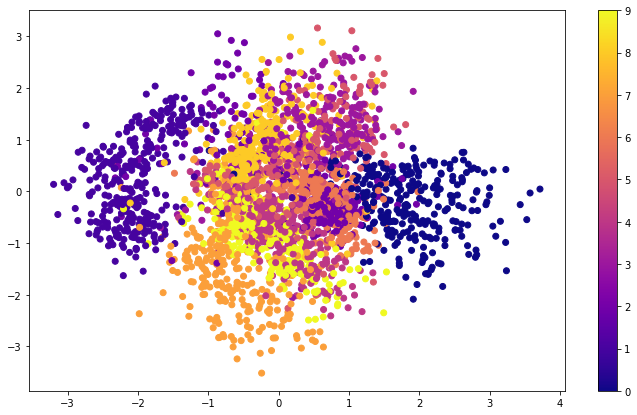

In [24]:
plt.figure(figsize=(12, 7))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='plasma')
plt.colorbar()
plt.show()

#### Decoder

In [25]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 350)               35350     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               275184    
Total params: 310,834
Trainable params: 310,834
Non-trainable params: 0
_________________________________________________________________


In [26]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [27]:
n = 21  
#每排有多少點
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

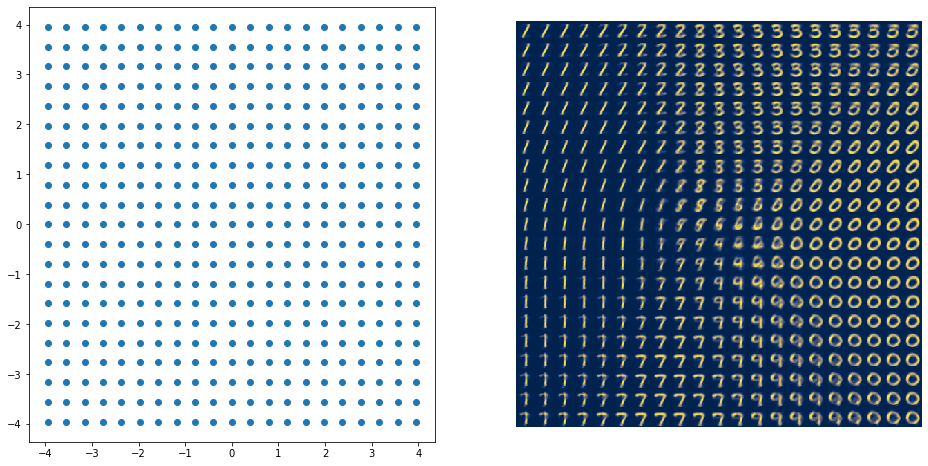

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='cividis')
plt.axis('off')
plt.show()